# running socioeconomic results with cdc subset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]
    

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

# thresh = 0.95
# raw['threshold'] = [1 if float(conf) > thresh else 0 for conf in raw['sent_confidence']]
# raw = raw[raw['threshold'] == 1]
raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1

raw['ff_ratio'] = raw['follower_count'] / (1+ raw['friends_count'])

raw = raw[raw['ff_ratio'] < 40178.53451847389]

splits = pd.to_datetime(['2020-03-13', '2020-05-27'])
colors = ['purple', 'orange', 'black']

raw['stage'] = ['s:1' if date < splits[0] else 's:2' if date < splits[1] else 's:3' for date in raw['date']]

raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,time,hour,is_negative,is_positive,state_name,state_abv,fips,count,ff_ratio,stage
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,07:03:44,7,0,1,Nevada,NV,32003,1,0.500000,s:1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,07:04:49,7,0,1,New York,NY,36081,1,0.917051,s:1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,07:05:30,7,0,1,Arizona,AZ,04013,1,1.793893,s:1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,07:10:48,7,1,0,Arkansas,AR,05119,1,1.172558,s:1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,07:11:11,7,1,0,Arkansas,AR,05119,1,1.172558,s:1


# subsetting for cdc keywords

In [2]:
keywords = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')

there are a total of 53272 tweets after subsetting for cdc keywords


# income df load

In [3]:
income = pd.read_csv('fips_unemp_medhh.csv')
income.head()

,FIPStxt,Stabr,area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,...,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,0,US,United States,NaN,NaN,NaN,"142,601,667","136,904,680","5,696,987",4.0,...,"161,389,026","155,102,319","6,286,707",3.9,"163,100,055","157,115,247","5,984,808",3.7,"61,937",NaN
1,1000,AL,Alabama,NaN,NaN,NaN,"2,133,223","2,035,594","97,629",4.6,...,"2,216,627","2,130,845","85,782",3.9,"2,241,747","2,174,483","67,264",3.0,"49,881",100.0
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,"21,720","20,846",874,4.0,...,"26,196","25,261",935,3.6,"26,172","25,458",714,2.7,"59,338",119.0
3,1003,AL,"Baldwin County, AL",3.0,2.0,1.0,"69,533","66,971","2,562",3.7,...,"95,233","91,809","3,424",3.6,"97,328","94,675","2,653",2.7,"57,588",115.5
4,1005,AL,"Barbour County, AL",6.0,6.0,0.0,"11,373","10,748",625,5.5,...,"8,414","7,987",427,5.1,"8,537","8,213",324,3.8,"34,382",68.9


# merge dataframes

In [4]:
stats_df = income[income['FIPStxt'].isin(raw['fips'].unique())][['FIPStxt', 'Unemployment_rate_2019', 'Median_Household_Income_2018', 'Med_HH_Income_Percent_of_State_Total_2018']]

stats_df.columns = ['fips', 'unemp_rate', 'median_hh', '%_state_total']

stats_df['median_hh'] = stats_df['median_hh'].replace(',','', regex = True)
stats_df['fips'] = stats_df['fips'].astype('str')
raw = pd.merge(cdc, stats_df, on='fips')

# had to pull peurto rico stats
raw = raw[~raw['median_hh'].isna()]
raw['median_hh'] = raw['median_hh'].astype('int')


raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,state_name,state_abv,fips,count,ff_ratio,stage,in_cdc,unemp_rate,median_hh,%_state_total
0,id:1226325348247310337,2020-02-09 02:02:01+00:00,1196.0,1661.0,39.0,117.0,Morrow,0,if they pulled the stuff in the sixties and se...,pulled stuff sixty seventy asse handed throw j...,...,Ohio,OH,39117,1,0.719615,s:1,1,4.1,60452,107.7
1,id:1233612267415097345,2020-02-29 04:37:38+00:00,823.0,1002.0,39.0,117.0,Morrow,0,so by correct handwashing amp other essential ...,correct handwash amp essential hygiene routine...,...,Ohio,OH,39117,1,0.820538,s:1,1,4.1,60452,107.7
2,id:1228783507033509890,2020-02-15 20:49:52+00:00,324.0,98.0,39.0,117.0,Morrow,0,this is a disaster waiting to happen,disaster waiting happen,...,Ohio,OH,39117,1,3.272727,s:1,1,4.1,60452,107.7
3,id:1227377430362492928,2020-02-11 23:42:37+00:00,3767.0,4007.0,39.0,117.0,Morrow,0,thousands of jobs went to because of bad polic...,thousand job go bad policy profit follow money...,...,Ohio,OH,39117,1,0.939870,s:1,1,4.1,60452,107.7
4,id:1233230888659451904,2020-02-28 03:22:10+00:00,156.0,162.0,39.0,117.0,Morrow,0,dear powers that be get these test kits develo...,dear power test kit develop mass produce send ...,...,Ohio,OH,39117,1,0.957055,s:1,1,4.1,60452,107.7


# stats on unemployment rate and median household income

In [5]:
print('median household income stats')
print(raw['median_hh'].describe())
print()
print('unemployment rate stats')
print(raw['unemp_rate'].describe())

median household income stats
count     40870.000000
mean      65723.964497
std       17698.484566
min       29380.000000
25%       52910.000000
50%       60862.000000
75%       76255.000000
max      140382.000000
Name: median_hh, dtype: float64

unemployment rate stats
count    40870.000000
mean         3.621304
std          0.883700
min          1.800000
25%          3.000000
50%          3.500000
75%          4.000000
max         12.200000
Name: unemp_rate, dtype: float64


# median household

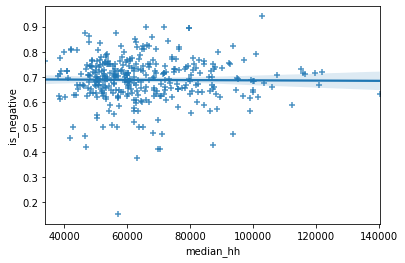

In [6]:
counties = raw.groupby(['fips']).agg({'is_negative':'mean', 'median_hh':'mean', 'unemp_rate':'mean', 'state_name':'max', 'count':'count'}).reset_index()

counties = counties[counties['count'] > 15]

sns.regplot(x='median_hh', y='is_negative', data=counties, marker='+')

# unemployment rate

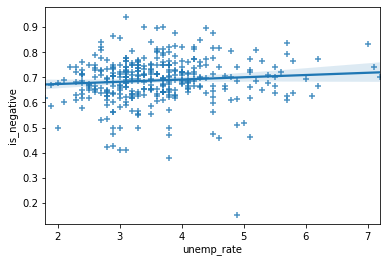

In [7]:
sns.regplot(x='unemp_rate', y='is_negative', data=counties, marker='+')

# pearsons r

In [8]:
 counties[['is_negative','unemp_rate','median_hh']].corr()

,is_negative,unemp_rate,median_hh
is_negative,1.000000,0.090690,-0.009571
unemp_rate,0.090690,1.000000,-0.433323
median_hh,-0.009571,-0.433323,1.000000


# pearsons r squared

In [9]:
 counties[['is_negative','unemp_rate','median_hh']].corr()**2

,is_negative,unemp_rate,median_hh
is_negative,1.000000,0.008225,0.000092
unemp_rate,0.008225,1.000000,0.187769
median_hh,0.000092,0.187769,1.000000


# very low correlations compared to non-cdc subsetted data

In [10]:
import scipy

x= counties['is_negative']
y= counties['unemp_rate']

print(scipy.stats.pearsonr(x, y))    # Pearson's r

print(scipy.stats.spearmanr(x, y))   # Spearman's rho

print(scipy.stats.kendalltau(x, y))  # Kendall's tau


(0.09068984261445594, 0.09165214819877834)
SpearmanrResult(correlation=0.13421629521854228, pvalue=0.012332531157621455)
KendalltauResult(correlation=0.09029193956978258, pvalue=0.012599055746778135)
